In [31]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['figure.frameon'] = True
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['font.size'] = 22
mpl.rcParams['legend.fontsize'] = 16

In [2]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import math

class SpinHamiltonian():
    def __init__(self):
        self.sx = qt.jmat(1,'x') # spin 1 x operator of nv center
        self.sy = qt.jmat(1,'y') # spin 1 y operator of nv center
        self.sz = qt.jmat(1,'z')        # spin 1 z operator of nv center

        self.ge = 28e9                  # gyromagnetic ratio of nv center
        self.D = 2.87e9                 # zero field splitting energy
        self.ms0 = 0 # energy (frequency) of ms=0 state. Initialized to 0. It is later changed by the code.

    def eigenstates(self,B,theta,z): # z is a flag to distinguish between parallel and perpendicular
        Bx = B*math.cos(theta) # calculating B from its magnitude, polar angle.
        By = B*math.sin(theta)
        Bz=0
        if z :
            Bx =0
            By =0
            Bz = B

        Hs = self.D*((self.sz*self.sz)-(2/3)*qt.qeye(3)) + self.ge*(Bz*self.sz + Bx*self.sx + By*self.sy)      # Electric term ignored as it is negligible
        return Hs.eigenstates() 

    def transition_frequencies(self,B,theta,z): 
        egvals = self.eigenstates(B,theta,z)[0]

        if(B == 0): 
            self.ms0 = egvals[0] 
        f1 = egvals[2] - self.ms0 if(z) else egvals[2]-egvals[0] # to distinguish parallel and perpendicular energies as qutip sorts them
        f0 = abs(egvals[1] + egvals[0] - (2*self.ms0)) if(z) else egvals[1]-egvals[0] # absolute value of frequency

        return np.array([f1,f0])

# Ground State Zeeman

The Hamiltonian is 
$\hat{H} = DS_{z}^{2} + \mu_{B} g_{e} \vec{B}\cdot\vec{S}$

In [55]:
nvspin = SpinHamiltonian()

B = np.linspace(0,.2,1000)
Btheta = 0
Bz = 0

ham = np.vectorize(nvspin.transition_frequencies, otypes=[np.ndarray])
trans_freqs = np.array(ham(B, 0, 0))
trans_freqs = np.array(trans_freqs.tolist())

ham = np.vectorize(nvspin.transition_frequencies, otypes=[np.ndarray])
trans_freqsz = np.array(ham(B, 0, 1))
trans_freqsz = np.array(trans_freqsz.tolist())

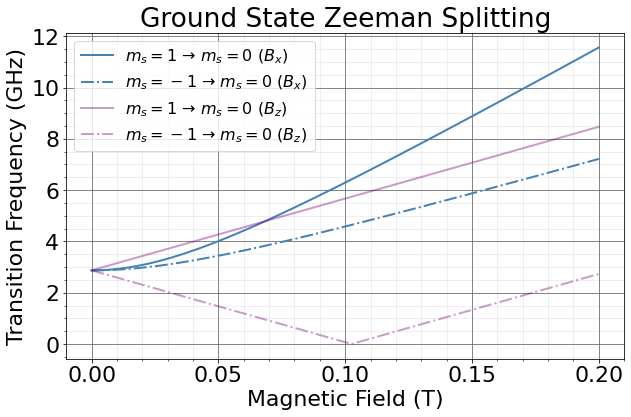

In [56]:
fig = plt.figure()
plt.plot(B, trans_freqs[:,0]/1e09, color='steelblue', label="$m_{s}=1$ \u2192 $m_{s}=0$ ($B_{x}$)")
plt.plot(B, trans_freqs[:,1]/1e09, '-.', color='steelblue', label="$m_{s}=-1$ \u2192 $m_{s}=0$ ($B_{x}$)")
plt.plot(B, trans_freqsz[:,0]/1e09, color='purple', alpha=.4, label="$m_{s}=1$ \u2192 $m_{s}=0$ ($B_{z}$)")
plt.plot(B, trans_freqsz[:,1]/1e09, '-.', color='purple', alpha=.4, label="$m_{s}=-1$ \u2192 $m_{s}=0$ ($B_{z}$)")

plt.xlabel('Magnetic Field (T)')
plt.ylabel('Transition Frequency (GHz)')
plt.title('Ground State Zeeman Splitting')

plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.legend()
plt.show()

# Zeeman Including Hyperfine

If the carbon atom adjacent to the vacancy is the isotope $^{13}$C, the hamitonian is also influenced by the hyperfine interactions between the nv-center electrons and the $^{13}$C nucleus owing to its 1/2 spin. In this case the hamiltonian takes the form:

$$\hat{H} = D S_{z}^{2} + \gamma_{e} \vec{B} \cdot \vec{S} + \gamma_{n} \vec{B} \cdot \vec{I} + \hat{H}_{hf}$$

$$\hat{H}_{hf} = A_{zz}S_{z}I_{z} + A_{xx}S_{x}I_{x} + A_{yy}S_{y}I_{y} + A_{xz}(S_{z}I_{x} + S_{x}I_{z}) $$

....where:

* $I_{i}$ is the i$^{th}$ component of the nuclear spin operator
* $A_{ij}$ is the ij$^{th}$ component of the Hyperfine tensor
* $\gamma_{n}$ is the gyromagnetic ratio of the $^{13}$C nucleus

When hyperfine interaction with a neighbouring 13C nucleus or any other spin half system are considered each of the energy levels is split into 2 sublevels. A total of 8 transitions exist from the ms = 0 state. Shown below is the resonance plot for the detected frequencies. Each line is split into two hyperfine lines. The frequency vs magnetic field graph shows an anticrossing or an avoided crossing at about B = 0.00225T. Since the energy of the ms=0 level and its hyperfine levels are close to each other and much less than the other levels, they would not affect the transition frequency if considered as separate levels. So all the energies of the ms=0 have been averaged out and that average has been considered to obtain the F vs B graph. Otherwise there would be 8 lines and not 4 as in the graph. 

In [57]:
class HyperfineSpinHalf():
    def __init__(self):
        self.sx = qt.jmat(1,'x')
        self.sy = qt.jmat(1,'y')
        self.sz = qt.jmat(1,'z')            # jmat is higher order spin operator. 1 in this case.
        self.ge = 28e9                      # gyromagnetic ratio of electron in Hz/T
        self.gc = 10.705e6                  # gyromagnetic ratio of C-13 nucleus in Hz/T for hyperfine interaction
        self.D = 2870.2e6                   # zero field splitting frequency in Hz

        self.Axx = 189.3e6
        self.Ayy = 128.4e6
        self.Azz = 128.9e6
        self.Axz = 24.1e6                   # Hyperfine Tensor components in NV frame of reference. Taken from reference 2.
        self.Ix = qt.jmat(0.5,'x')
        self.Iy = qt.jmat(0.5,'y')
        self.Iz = qt.jmat(0.5,'z')          # Spin 1/2 operators for C-13 nucleus

        self.comp1 = self.Axx*qt.tensor(self.sx,self.Ix)
        self.comp2 = self.Ayy*qt.tensor(self.sy,self.Iy)
        self.comp3 = self.Azz*qt.tensor(self.sz,self.Iz)
        self.comp4 = self.Axz*(qt.tensor(self.sx,self.Iz)+qt.tensor(self.sz,self.Ix))
        self.Hhf = self.comp1 + self.comp2 + self.comp3 + self.comp4

    def transitionFreqs(self,Bz):
        H = self.D*(qt.tensor(self.sz*self.sz,qt.qeye(2))-(2/3)*qt.tensor(qt.qeye(3),qt.qeye(2))) + self.ge*Bz*qt.tensor(self.sz,qt.qeye(2)) + self.gc*Bz*qt.tensor(qt.qeye(3),self.Iz) + self.Hhf 
        egvals = H.eigenstates()[0]

        ms0 = (egvals[0] + egvals[1])/2		# zero level frequency averaged for simpler B vs F graph
        return np.array([egvals[2]-ms0, egvals[3]-ms0, egvals[4]-ms0, egvals[5]-ms0])

    def eigenvalues(self,Bz):
        H = self.D*(qt.tensor(self.sz*self.sz,qt.qeye(2))-(2/3)*qt.tensor(qt.qeye(3),qt.qeye(2))) + self.ge*Bz*qt.tensor(self.sz,qt.qeye(2)) + self.gc*Bz*qt.tensor(qt.qeye(3),self.Iz) + self.Hhf 
        return H.eigenstates()[0]

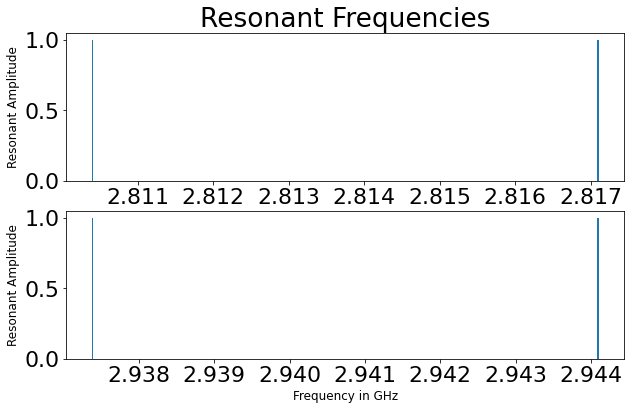

In [59]:
ham = HyperfineSpinHalf()

def resonance_plotter():
    # Plotting Hyperfine Resonant frequencies

    # generating all possible frequency transitions
    reso = np.full((8),1)
    freq = []
    egsts = ham.eigenvalues(1.199e-4)
    for i in range (2):
        for j in range (2,6):
            freq.append(egsts[j]-egsts[i])

    # plot first 4 frequencies
    freq = np.sort(freq)*0.000000001
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    ax1.set_ylabel('Resonant Amplitude',fontsize=12)
    ax1.set_title("Resonant Frequencies")
    ax1.bar(freq[0:4],reso[0:4],width=0.000007,bottom=None)

    # plot next 4 frequencies
    ax2 = fig.add_subplot(212)
    ax2.set_xlabel('Frequency in GHz',fontsize=12)
    ax2.set_ylabel('Resonant Amplitude',fontsize=12)
    ax2.bar(freq[4:8],reso[4:8],width=0.000007,bottom=None)
    plt.show()

if __name__== '__main__':
    resonance_plotter()

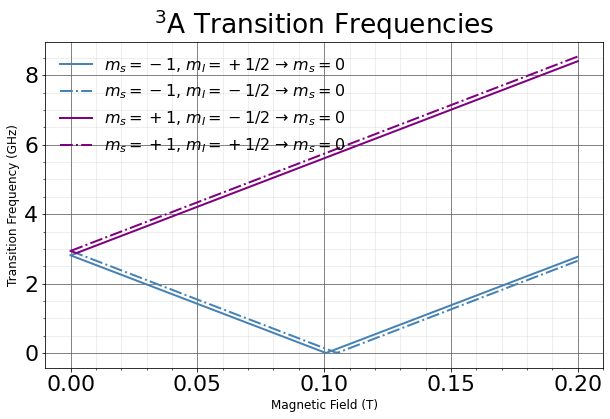

In [72]:
def BvsF_plotter():
    # B covers fields until the point where ms=-1 does not fall below ms=0
    # Bzoom is for the zoomed graph
    Bz = np.linspace(0,1e-2,100)
    hpham = np.vectorize(ham.transitionFreqs, otypes=[np.ndarray])
    freqs = np.array(hpham(Bz))
    freqs = np.array(freqs.tolist())

    # Qutip by default arranges eigenvalues in sorted order. This never gives a negative frequency. So the graph has to be extended logically.
    # calculating slope array
    b1 = 1e-2
    f1 = hpham(b1)
    b2 = 0.8e-2
    f2 = hpham(b2)
    m = (f2-f1)/(b2-b1)

    # adding higher magnetic field values
    Bzext = np.linspace(1e-2,0.2,200)
    fext = np.absolute(np.outer(Bzext-b1,m) + f1)

    #appending B and f arrays
    Bz = np.append(Bz,Bzext)
    freqs = np.append(freqs,fext,axis=0)

    fig,ax = plt.subplots()
#     ax = plt.subplot2grid((5,5),(0,0),rowspan=5,colspan=3)  # for proper sizing and placement of graph
    ax.set_xlabel("Magnetic Field (T)",fontsize=12)
    ax.set_ylabel("Transition Frequency (GHz)", fontsize=12)
    ax.set_title("$^{3}$A Transition Frequencies")
    ax.plot(Bz,freqs[:,0]/1e09,color='steelblue',label="$m_{s}=-1$, $m_{I}=+1/2$ \u2192 $m_{s}=0$") 
    ax.plot(Bz,freqs[:,1]/1e09,'-.',color='steelblue',label="$m_{s}=-1$, $m_{I}=-1/2$ \u2192 $m_{s}=0$") 
    ax.plot(Bz,freqs[:,2]/1e09,color='purple',label="$m_{s}=+1$, $m_{I}=-1/2$ \u2192 $m_{s}=0$") 
    ax.plot(Bz,freqs[:,3]/1e09,'-.',color='purple',label="$m_{s}=+1$, $m_{I}=+1/2$ \u2192 $m_{s}=0$") 
    ax.legend(frameon=False)
    # insert gridlines
    plt.grid(b=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    
    plt.show()

if __name__ == '__main__':
    BvsF_plotter()

# Stark Interaction 

# Excited State Splitting

The Hamiltonian is 

$$\hat{H} = D_{es}S_{z}^{2} + E_{es}(S_{x}^{2}-S_{y}^{2}) + \mu_{B} g_{e} B_{z}\cdot S_{z} - A_{es}(S_{x} + S_{y} + S_{z})$$

* $D_{es} = 1.425 \pm 003$ GHz is the excited state zero field splitting frequency
* $A_{es} = 61 \pm 6$ MHz is the hyperfine splitting constant
* $g_{e} = 2.01 \pm 0.01$ is the g factor
* $E_{es} = 70 \pm 30$ MHz is the strain constant

In [46]:
class ExcitedState():
    def __init__(self):
        self.sx1 = qt.jmat(1,'x')
        self.sy1 = qt.jmat(1,'y')
        self.sz1 = qt.jmat(1,'z')            
        self.Aes = 61e6 # hyperfine constant in Hz
        self.sx = qt.jmat(0.5,'x')
        self.sy = qt.jmat(0.5,'y')
        self.sz = qt.jmat(0.5,'z')
        self.D = 1.425e9 # zero field splitting in Hz
        self.g = 28e9 # gyromagnetic ratio
        self.Ees = 70e6 # Strain constant. doubtful value. there is a +-30MHz error

        dot1 = qt.tensor(self.sx1,self.sx)
        dot2 = qt.tensor(self.sy1,self.sy)
        dot3 = qt.tensor(self.sz1,self.sz)
        self.dot = dot1 + dot2 + dot3

    def eigenvalues(self,Bz):
        H = self.D*qt.tensor(self.sz1*self.sz1,qt.qeye(2)) + self.Ees*qt.tensor(((self.sx1*self.sx1)-(self.sy1*self.sy1)),qt.qeye(2)) + self.g*Bz*qt.tensor(self.sz1,qt.qeye(2)) - self.Aes*self.dot 
        return H.eigenstates()[0]

    def transitionFreqs(self,Bz):
        ham = np.vectorize(self.eigenvalues, otypes=[np.ndarray])
        egvals = ham(Bz)

        ms0 = (egvals[0]+egvals[1])/2
        return np.array([(egvals[2]-ms0),(egvals[3]-ms0),(egvals[4]-ms0),(egvals[5]-ms0)])

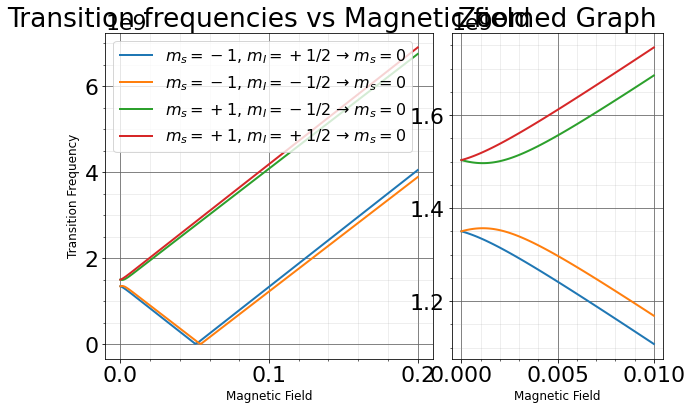

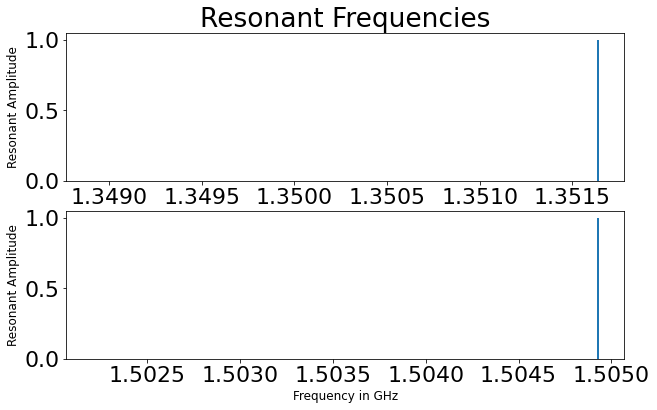

In [51]:
es = ExcitedState()

def resonance_plotter():
    # generating all possible frequencies
    reso = np.full((8),1)
    egv = es.eigenvalues(1.199e-4)			# Bz = 1.199e-4 for plotting resonance frequencies
    freq = []
    for i in range (2):
        for j in range (2,6):
            freq.append(egv[j]-egv[i])

    # plot first 4 frequencies
    freq = np.sort(freq)*0.000000001
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    ax1.set_ylabel('Resonant Amplitude',fontsize=12)
    ax1.set_title("Resonant Frequencies")
    ax1.bar(freq[0:4],reso[0:4],width=0.000003,bottom=None)

    # plot next 4 frequencies
    ax2 = fig.add_subplot(212)
    ax2.set_xlabel('Frequency in GHz',fontsize=12)
    ax2.set_ylabel('Resonant Amplitude',fontsize=12)
    ax2.bar(freq[4:8],reso[4:8],width=0.000003,bottom=None)
    plt.show()


def BvsF_plotter():
    # B covers fields until the point where ms=-1 does not fall below ms=0
    # Bzoom is for the zoomed graph
    hpham = np.vectorize(es.transitionFreqs, otypes = [np.ndarray])
    B = np.linspace(0,1e-2,100)
    Bzoom = np.linspace(0,1e-2,100)
    freqs = np.array(hpham(B))
    freqs_zoom = np.array(hpham(Bzoom))
    freqs = np.array(freqs.tolist())
    freqs_zoom = np.array(freqs_zoom.tolist())

    #calculating slope array
    b1 = 1e-2
    f1 = hpham(b1)
    b2 = 0.8e-2
    f2 = hpham(b2)
    m = (f2-f1)/(b2-b1)

    #adding higher magnetic field values
    Bext = np.linspace(1e-2,0.2,100)
    fext = np.absolute(np.outer(Bext-b1,m) + f1)

    #appending B and f arrays
    B = np.append(B,Bext)
    freqs = np.append(freqs,fext,axis=0)

    fig = plt.figure()
    ax = plt.subplot2grid((5,5),(0,0),rowspan=5,colspan=3)  # for proper sizing and placement of graph
    ax.set_xlabel("Magnetic Field",fontsize=12)
    ax.set_ylabel("Transition Frequency", fontsize=12)
    ax.set_title("Transition frequencies vs Magnetic field")
    ax.plot(B,freqs[:,0],label="$m_{s}=-1$, $m_{I}=+1/2$ \u2192 $m_{s}=0$") 
    ax.plot(B,freqs[:,1],label="$m_{s}=-1$, $m_{I}=-1/2$ \u2192 $m_{s}=0$") 
    ax.plot(B,freqs[:,2],label="$m_{s}=+1$, $m_{I}=-1/2$ \u2192 $m_{s}=0$") 
    ax.plot(B,freqs[:,3],label="$m_{s}=+1$, $m_{I}=+1/2$ \u2192 $m_{s}=0$") 
    ax.legend()
    plt.grid(b=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

    axz = plt.subplot2grid((5,5),(0,3),rowspan=5,colspan=2)  # for proper sizing and placement of graph
    axz.set_xlabel("Magnetic Field",fontsize=12)
    axz.set_title("Zoomed Graph")
    axz.plot(Bzoom,freqs_zoom[:,0],label="$m_{s}=-1$, $m_{I}=+1/2$ \u2192 $m_{s}=0$") 
    axz.plot(Bzoom,freqs_zoom[:,1],label="$m_{s}=-1$, $m_{I}=-1/2$ \u2192 $m_{s}=0$") 
    axz.plot(Bzoom,freqs_zoom[:,2],label="$m_{s}=+1$, $m_{I}=-1/2$ \u2192 $m_{s}=0$") 
    axz.plot(Bzoom,freqs_zoom[:,3],label="$m_{s}=+1$, $m_{I}=+1/2$ \u2192 $m_{s}=0$") 
    axz.locator_params(axis='x', nbins=4)  			# to reduce crowding of ticks
    plt.grid(b=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

    plt.show()

if __name__ == '__main__':
    BvsF_plotter()
    resonance_plotter()

In [ ]:
es = ExcitedState()

def resonance_plotter(self):
	# generating all possible frequencies
	reso = np.full((8),1)
	egv = es.eigenvalues(1.199e-4)			# Bz = 1.199e-4 for plotting resonance frequencies
	freq = []
	for i in range (2):
		for j in range (2,6):
			freq.append(egv[j]-egv[i])
			
	# plot first 4 frequencies
	freq = np.sort(freq)*0.000000001
	fig = plt.figure()
	ax1 = fig.add_subplot(211)
	ax1.set_ylabel('Resonant Amplitude',fontsize=12)
	ax1.set_title("Resonant Frequencies")
	ax1.bar(freq[0:4],reso[0:4],width=0.000003,bottom=None)
	
	# plot next 4 frequencies
	ax2 = fig.add_subplot(212)
	ax2.set_xlabel('Frequency in GHz',fontsize=12)
	ax2.set_ylabel('Resonant Amplitude',fontsize=12)
	ax2.bar(freq[4:8],reso[4:8],width=0.000003,bottom=None)
	plt.show()
		
def BvsF_plotter():
	# B covers fields until the point where ms=-1 does not fall below ms=0
	# Bzoom is for the zoomed graph
	hpham = np.vectorize(es.transitionFreqs, otypes = [np.ndarray])
	B = np.linspace(0,1e-2,100)
	Bzoom = np.linspace(0,1e-2,100)
	freqs = np.array(hpham(B))
	freqs_zoom = np.array(hpham(Bzoom))
	freqs = np.array(freqs.tolist())
	freqs_zoom = np.array(freqs_zoom.tolist())
	
	#calculating slope array
	b1 = 1e-2
	f1 = hpham(b1)
	b2 = 0.8e-2
	f2 = hpham(b2)
	m = (f2-f1)/(b2-b1)
	
	#adding higher magnetic field values
	Bext = np.linspace(1e-2,0.2,100)
	fext = np.absolute(np.outer(Bext-b1,m) + f1)
	
	#appending B and f arrays
	B = np.append(B,Bext)
	freqs = np.append(freqs,fext,axis=0)
	
	fig = plt.figure()
	ax = plt.subplot2grid((5,5),(0,0),rowspan=5,colspan=3)  # for proper sizing and placement of graph
	ax.set_xlabel("Magnetic Field",fontsize=12)
	ax.set_ylabel("Transition Frequency", fontsize=12)
	ax.set_title("Transition frequencies vs Magnetic field")
	ax.plot(B,freqs[:,0],label="$m_{s}=-1$, $m_{I}=+1/2$ \u2192 $m_{s}=0$") 
	ax.plot(B,freqs[:,1],label="$m_{s}=-1$, $m_{I}=-1/2$ \u2192 $m_{s}=0$") 
	ax.plot(B,freqs[:,2],label="$m_{s}=+1$, $m_{I}=-1/2$ \u2192 $m_{s}=0$") 
	ax.plot(B,freqs[:,3],label="$m_{s}=+1$, $m_{I}=+1/2$ \u2192 $m_{s}=0$") 
	ax.legend()
	plt.grid(b=True, which='major', color='#666666', linestyle='-')
	plt.minorticks_on()
	plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
	
	axz = plt.subplot2grid((5,5),(0,3),rowspan=5,colspan=2)  # for proper sizing and placement of graph
	axz.set_xlabel("Magnetic Field",fontsize=12)
	axz.set_title("Zoomed Graph")
	axz.plot(Bzoom,freqs_zoom[:,0],label="$m_{s}=-1$, $m_{I}=+1/2$ \u2192 $m_{s}=0$") 
	axz.plot(Bzoom,freqs_zoom[:,1],label="$m_{s}=-1$, $m_{I}=-1/2$ \u2192 $m_{s}=0$") 
	axz.plot(Bzoom,freqs_zoom[:,2],label="$m_{s}=+1$, $m_{I}=-1/2$ \u2192 $m_{s}=0$") 
	axz.plot(Bzoom,freqs_zoom[:,3],label="$m_{s}=+1$, $m_{I}=+1/2$ \u2192 $m_{s}=0$") 
	axz.locator_params(axis='x', nbins=4)  			# to reduce crowding of ticks
	plt.grid(b=True, which='major', color='#666666', linestyle='-')
	plt.minorticks_on()
	plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
	
	plt.show()
		
if __name__ == '__main__':
	BvsF_plotter()
	resonance_plotter()